We train CIFAR10 using a DenseNet.
We use the provided keras version of the architecture: https://keras.io/api/applications/.

From [paperswithcode](https://paperswithcode.com/paper/densely-connected-convolutional-networks),
the should achieve ~96% natural accuracy.

### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load data

In [3]:
def plot_images(xs, flat=True, channels=1):
    for i, x in enumerate(xs):
        plt.subplot(1, len(xs), i + 1)
        plt.imshow(x)
        plt.axis("off")

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


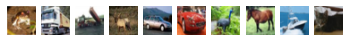

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

plot_images(x_train[:10])

In [5]:
model = keras.applications.DenseNet121(
    weights=None,
    input_shape=x_train[0].shape,
    classes=10,
)
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

In [6]:
model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=10,
    validation_data=(x_test, y_test),
    verbose=1,
)

Epoch 1/10
116/196 [================>.............] - ETA: 1:17 - loss: 2.1081 - accuracy: 0.3444

KeyboardInterrupt: 

In [ ]:
def run_experiment(
    dim,
    s1,
    s2,
    model_layers,
    train_batch_size,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    attack_batch_size=1024,
    num_train=5 * 10 ** 4,
    num_test=10 ** 4,
    seed=42
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_normal_data(
        dim=dim, s1=s1, s2=s2,
        num_samples=num_train,
    )

    x_test, y_test = generate_normal_data(
        dim=dim, s1=s1, s2=s2,
        num_samples=num_test,
    )
    
    model = keras.Sequential(
        [keras.Input(shape=x_train[0].shape)]
        + model_layers
    )
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.fit(
        x_train,
        y_train,
        batch_size=train_batch_size,
        epochs=train_epochs,
        validation_data=(x_test, y_test),
        verbose=2,
    )
    model.trainable = False
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        clip_values=[-x_test.max(), x_test.max()],
    )
    art_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    x_train_adv = art_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv = art_attack.generate(x_test, y=y_test)
    
    _, nat_train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, adv_train_acc = model.evaluate(x_train_adv, y_train[:num_test], verbose=0)
    _, adv_test_acc = model.evaluate(x_test_adv, y_test, verbose=0)
    
    print("Nat train acc :", nat_train_acc)
    print("Nat test  acc :", nat_test_acc)
    print("Adv train acc :", adv_train_acc)
    print("Adv test  acc :", adv_test_acc)
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv=x_train_adv,
        x_test_adv=x_test_adv,
    )